In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

In [2]:
data = pd.read_csv('US-airline-Tweets.csv') # https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df = data[['text','airline_sentiment']]

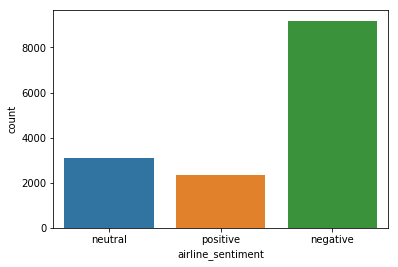

In [5]:
sns.countplot(df['airline_sentiment'])

In [6]:
df.describe()

,text,airline_sentiment
count,14640,14640
unique,14427,3
top,@united thanks,negative
freq,6,9178


In [7]:
df.isnull().sum()

text                 0
airline_sentiment    0
dtype: int64

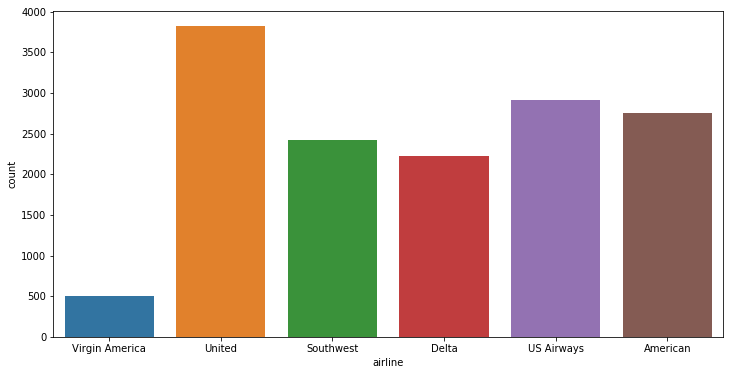

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(data['airline'])

In [9]:
import re
import nltk
from nltk.corpus import stopwords

In [10]:
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

In [11]:
def stopword(input_text):
    stopwords_list = stopwords.words('english')
    white_list = ["no","not","n't"]
    words = input_text.split()
    clean_text =[word for word in words if (words not in stopwords_list or word in white_list) and len(words)>1]
    return " ".join(clean_text)
            

In [12]:
df['text'] = df.text.apply(remove_mentions).apply(stopword)

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
df.head()

,text,airline_sentiment
0,What said.,neutral
1,plus you've added commercials to the experienc...,positive
2,I didn't today... Must mean I need to take ano...,neutral
3,"it's really aggressive to blast obnoxious ""ent...",negative
4,and it's a really big bad thing about it,negative


In [14]:
df['airline_sentiment'] = df['airline_sentiment'].map({'neutral':0,'positive':1,'negative':2})

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
labels = np.asarray(df['airline_sentiment'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],labels , test_size=0.3, random_state=101)

In [19]:
tokenizer = Tokenizer(num_words=10000,oov_token=True) # size of dictionary is 10000 most common words, words not in dict are replace by 00v

In [20]:
tokenizer.fit_on_texts(X_train)

In [21]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences,maxlen=100)

In [22]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences,maxlen=100)

In [23]:
len(tokenizer.word_index)

12228

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM,Dropout

In [25]:
model1 = Sequential()
model1.add(Embedding(10000,64,input_length=100))
model1.add(LSTM(128))
model1.add(Dense(3,activation='softmax'))
model1.summary()

model1.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 739,203
Trainable params: 739,203
Non-trainable params: 0
_________________________________________________________________


In [26]:
model1.fit(train_padded,y_train,epochs=5,validation_split=0.2)

Train on 8198 samples, validate on 2050 samples
Epoch 1/5
8198/8198 [==============================] - 52s 6ms/sample - loss: 0.7145 - accuracy: 0.7041 - val_loss: 0.6631 - val_accuracy: 0.7659
Epoch 2/5
8198/8198 [==============================] - 48s 6ms/sample - loss: 0.4510 - accuracy: 0.8273 - val_loss: 0.5149 - val_accuracy: 0.8161
Epoch 3/5
8198/8198 [==============================] - 46s 6ms/sample - loss: 0.2898 - accuracy: 0.8909 - val_loss: 0.5662 - val_accuracy: 0.8122
Epoch 4/5
8198/8198 [==============================] - 46s 6ms/sample - loss: 0.1944 - accuracy: 0.9317 - val_loss: 0.6347 - val_accuracy: 0.7961
Epoch 5/5
8198/8198 [==============================] - 47s 6ms/sample - loss: 0.1431 - accuracy: 0.9475 - val_loss: 0.6822 - val_accuracy: 0.7829


In [27]:
losses = pd.DataFrame(model1.history.history)

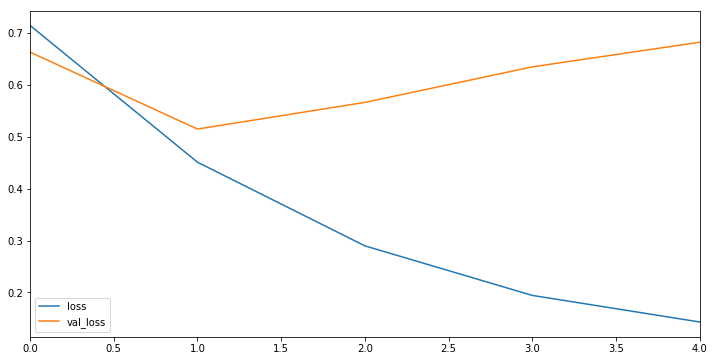

In [28]:
losses[['loss','val_loss']].plot(figsize=(12,6))

In [29]:
from sklearn.metrics import confusion_matrix,classification_report

In [30]:
pred = model1.predict_classes(test_padded)

In [31]:
confusion_matrix(y_test,pred)

array([[ 546,   92,  309],
       [ 128,  427,  152],
       [ 269,   65, 2404]], dtype=int64)

In [32]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       947
           1       0.73      0.60      0.66       707
           2       0.84      0.88      0.86      2738

   micro avg       0.77      0.77      0.77      4392
   macro avg       0.72      0.69      0.70      4392
weighted avg       0.77      0.77      0.77      4392



In [48]:
conv_model = Sequential()
conv_model.add(Embedding(10000,100,input_length=100))

#conv_model.add(Conv1D(128,3,activation='relu'))
#conv_model.add(MaxPooling1D(3))
conv_model.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
conv_model.add(GlobalMaxPooling1D())
conv_model.add(Dropout(0.5))
conv_model.add(Dense(256,activation='relu'))
conv_model.add(Dense(3,activation='softmax'))

conv_model.summary()

conv_model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 99, 100)           20100     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 1,046,727
Trainable params: 1,046,727
Non-trainable params: 0
___________________________________________

In [49]:
conv_model.fit(train_padded,y_train,epochs=5,validation_split=0.2)

Train on 8198 samples, validate on 2050 samples
Epoch 1/5
8198/8198 [==============================] - 12s 1ms/sample - loss: 0.7706 - accuracy: 0.6687 - val_loss: 0.5997 - val_accuracy: 0.7776
Epoch 2/5
8198/8198 [==============================] - 11s 1ms/sample - loss: 0.5214 - accuracy: 0.7995 - val_loss: 0.5380 - val_accuracy: 0.7937
Epoch 3/5
8198/8198 [==============================] - 10s 1ms/sample - loss: 0.3790 - accuracy: 0.8597 - val_loss: 0.5592 - val_accuracy: 0.7995
Epoch 4/5
8198/8198 [==============================] - 10s 1ms/sample - loss: 0.2620 - accuracy: 0.9025 - val_loss: 0.6552 - val_accuracy: 0.7907
Epoch 5/5
8198/8198 [==============================] - 10s 1ms/sample - loss: 0.1882 - accuracy: 0.9327 - val_loss: 0.7248 - val_accuracy: 0.7878


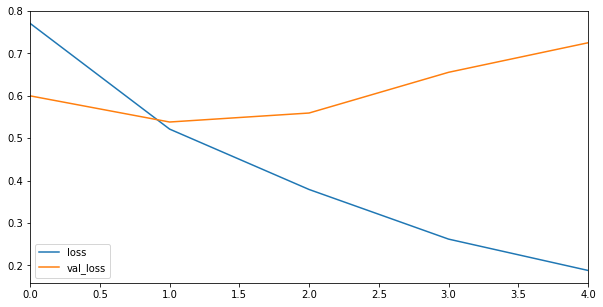

In [50]:
conv_loss = pd.DataFrame(conv_model.history.history)
conv_loss[['loss','val_loss']].plot(figsize=(10,5))

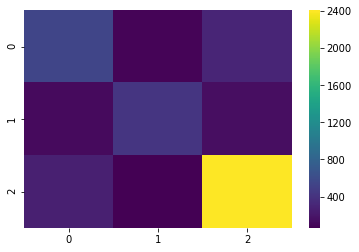

In [53]:
conv_pred = model1.predict_classes(test_padded)
sns.heatmap(confusion_matrix(y_test,pred),cmap='viridis')

In [52]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       947
           1       0.73      0.60      0.66       707
           2       0.84      0.88      0.86      2738

   micro avg       0.77      0.77      0.77      4392
   macro avg       0.72      0.69      0.70      4392
weighted avg       0.77      0.77      0.77      4392

